In [74]:
import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

auth_url = "https://www.strava.com/oauth/token"
activites_url = "https://www.strava.com/api/v3/athlete/activities"

payload = {
    'client_id': "73446",
    'client_secret': '1372749daff6b1fcfba10d133829e12fa0ef3829',
    'refresh_token': 'f5e435d6ca868b3efa23f99ae5c00d4dafcbdb23',
    'grant_type': "refresh_token",
    'f': 'json'
}

print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
print("Access Token = {}\n".format(access_token))

header = {'Authorization': 'Bearer ' + access_token}
param = {'per_page': 200, 'page': 1}
my_dataset = requests.get(activites_url, headers=header, params=param).json()


Requesting Token...

Access Token = 20eecc8e01fceb9ff7bd2d5e73f9ecc26b37d565



In [75]:
import pandas as pd
from pandas import json_normalize
#Seaborn is a data visualization library.
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
activities = json_normalize(my_dataset)
activities.shape

(145, 55)

In [76]:
#select only the relevant columns
cols = ['name', 'type', 'distance', 'moving_time',   
         'average_speed', 'max_speed','total_elevation_gain',
         'start_date_local'
       ]
activities = activities[cols]
#Break date into start time and date
activities['start_date_local'] = pd.to_datetime(activities['start_date_local'])
activities['start_time'] = activities['start_date_local'].dt.time
activities['start_date_local'] = activities['start_date_local'].dt.date
activities.head(5)


,name,type,distance,moving_time,average_speed,max_speed,total_elevation_gain,start_date_local,start_time
0,Lunch Run,Run,10052.9,2566,3.918,7.293,104.0,2021-10-27,11:27:54
1,Evening Run,Run,10703.1,3283,3.260,6.526,89.0,2021-10-26,18:15:42
2,Evening Run,Run,9963.9,3219,3.095,6.416,69.0,2021-10-19,18:02:40
3,Afternoon Swim,Swim,1800.0,2215,0.813,5.000,0.0,2021-10-18,16:42:56
4,Semi trail de la brie des morins,Run,20811.0,5587,3.720,7.300,377.0,2021-10-17,09:38:18


In [55]:
def convTime(metSec):
    '''
    A fontion to convert m/s to min/km
    '''
    minDecimal = 1000/(metSec)
    minutes = int(minDecimal)
    secondes = int((minDecimal*60) % 60)
    return minDecimal#str(minutes)+'min'+str(secondes)


In [72]:
activities['kilometer'] = activities['distance'].apply(lambda x: x/1000)#convert meter to kilometer
activities['avg_speed_minKm'] = activities['average_speed'].apply(lambda x: convTime(x))#apply m/s to min/km
activities['avg_speed_minKm'] = pd.to_datetime(activities['avg_speed_minKm'], unit='s').dt.strftime("%H:%M:%S")

#now let's add what was the weekday
activities['weekday'] = activities['start_date_local'].apply(lambda x: ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'][x.weekday()])
activities['weekday'] = pd.Categorical(activities['weekday'],
                                  categories=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],
                                  ordered=True)


In [70]:
runs = activities.loc[activities['type'] == 'Run']#select only the runs activity
runs.head(5)

,name,type,distance,moving_time,average_speed,max_speed,total_elevation_gain,start_date_local,start_time,kilometer,avg_speed_minKm,weekday
0,Lunch Run,Run,10052.9,2566,3.918,7.293,104.0,2021-10-27,11:27:54,10.0529,00:04:15,Mer
1,Evening Run,Run,10703.1,3283,3.260,6.526,89.0,2021-10-26,18:15:42,10.7031,00:05:06,Mar
2,Evening Run,Run,9963.9,3219,3.095,6.416,69.0,2021-10-19,18:02:40,9.9639,00:05:23,Mar
4,Semi trail de la brie des morins,Run,20811.0,5587,3.720,7.300,377.0,2021-10-17,09:38:18,20.8110,00:04:28,Dim
5,Afternoon Run,Run,12642.7,3830,3.301,6.100,126.0,2021-10-15,17:30:40,12.6427,00:05:02,Ven


<AxesSubplot:xlabel='kilometer', ylabel='average_speed'>

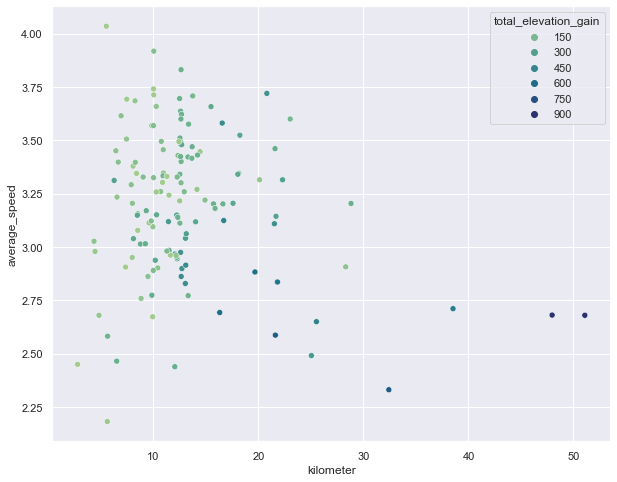

In [66]:
sns.set(rc={"figure.figsize":(10, 8)}) 
sns.scatterplot(data=runs, x="kilometer", y="average_speed", hue="total_elevation_gain", palette="crest")
#plt.savefig("scatterplot1.png")

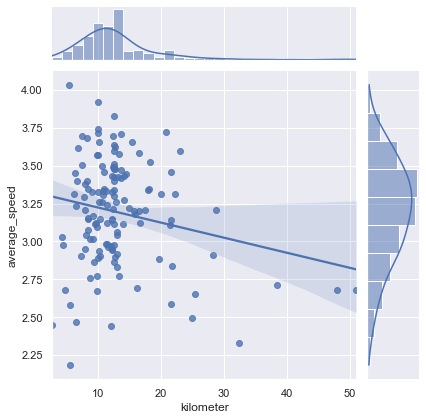

In [67]:
sns.jointplot(x = "kilometer", y = "average_speed", data=runs, kind='reg')
#plt.savefig("jointplot1.png")

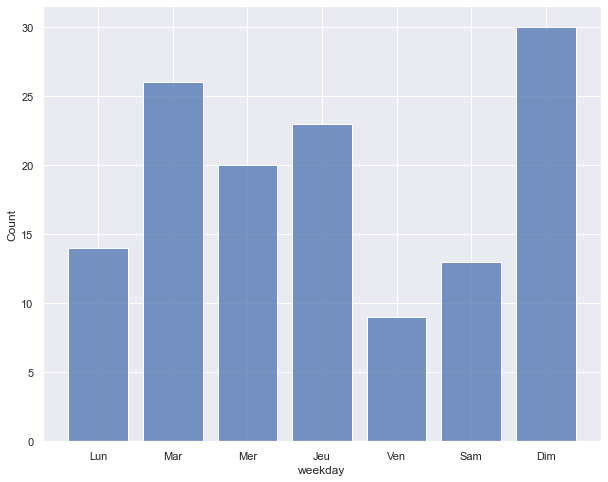

In [69]:
sns.histplot(data=runs, x="weekday", shrink=.8)
plt.savefig("histplot.png")